# ☕ BERT ด้วย PyTorch สำหรับวิเคราะห์รีวิวกาแฟ

ยินดีต้อนรับสู่บทเรียน PyTorch สำหรับการวิเคราะห์ความรู้สึกของรีวิวกาแฟด้วยโมเดล BERT! เราจะพาคุณเรียนรู้ตั้งแต่การโหลดข้อมูล เตรียมข้อความ ไปจนถึงการฝึกสอนและใช้งานโมเดล BERT บนรีวิวกาแฟจริงๆ

---

## 📘 บทนำ

**PyTorch** เป็นเฟรมเวิร์ก Deep Learning ยอดนิยมจาก Meta (Facebook) ที่ใช้งานง่าย ยืดหยุ่น และเหมาะกับการทดลองโมเดลเชิงลึก โดยเฉพาะบน GPU ซึ่งในบทเรียนนี้ เราจะใช้ PyTorch ร่วมกับ Transformers (BERT) เพื่อวิเคราะห์ความรู้สึกจากรีวิวกาแฟของผู้บริโภค
โมเดลที่เราเลือกใช้คือ **BERT (Bidirectional Encoder Representations from Transformers)** ซึ่งเป็นโมเดลภาษาเชิงลึกที่สามารถเข้าใจบริบทของคำในประโยคได้ทั้งสองทิศทาง ช่วยให้เข้าใจรีวิวที่มีภาษาซับซ้อน หรือคำบรรยายรสชาติได้อย่างแม่นยำ

### 🧾 เกี่ยวกับ Dataset รีวิวกาแฟ

ชุดข้อมูลนี้รวบรวมรีวิวกาแฟจากผู้ชิมมืออาชีพ ซึ่งประกอบด้วยข้อมูลหลายมิติ ทั้งคำบรรยายรส กลิ่น เนื้อสัมผัส รวมถึงคะแนนประเมินโดยรวม

- 📝 คอลัมน์ข้อความรีวิว: เช่น "Blind Assessment", "Notes", "Bottom Line"
- 🌟 คะแนน (Rating): ใช้เป็นเกณฑ์ในการแปลงเป็น sentiment (positive/negative)  
- 🧠 เป้าหมายของเรา: สร้างโมเดลที่สามารถวิเคราะห์ข้อความรีวิว แล้วทำนายว่ารีวิวนั้นมี ความรู้สึกเชิงบวกหรือไม่

🎯 ชุดข้อมูลนี้เหมาะสำหรับการฝึกทำ NLP เบื้องต้น โดยเฉพาะการนำโมเดล BERT มาประยุกต์ใช้งานจริงกับรีวิวที่มีความหมายหลากหลาย
---

## 🛠️ ขั้นตอนที่ 1: เตรียมสภาพแวดล้อม (Environment Setup)

ก่อนเริ่มใช้งาน Jupyter Notebook และ PyTorch แนะนำให้สร้าง Python Environment แยกต่างหาก

### 🔹 1. สร้าง Virtual Environment
```bash
python -m venv env-pytorch
```

### 🔹 2. เปิดใช้งาน Environment
```bash
source env-pytorch/bin/activate
```

### 🔹 3. ติดตั้ง Library ที่จำเป็น
```bash
pip install -r requirements.txt
```

### 🔹 4. เพิ่ม Environment นี้ให้ Jupyter ใช้งาน
```bash
python -m ipykernel install --user --name=env-pytorch --display-name "Python (env-pytorch)"
```

---

## 🔄 ขั้นตอนที่ 2: เปิด Notebook และเลือก Kernel

เมื่อเปิด Jupyter Notebook แล้ว:

1. คลิกที่ชื่อ Kernel ปัจจุบัน (เช่น "Python 3") ที่มุมบนขวา
![ipykernel](../image/kernel.png)

3. เลือก Kernel ที่ชื่อ "Python (env-pytorch)" (ตามที่ตั้งไว้ในขั้นตอนก่อน)
![select ](../image/pythroch.png)
> 💡 หากยังไม่เห็นชื่อ Kernel นี้ ให้ลองปิด/เปิด Jupyter ใหม่ หรือเช็กคำสั่ง ipykernel อีกครั้ง

---

## 💻 ขั้นตอนที่ 3: เริ่มเขียนโค้ด PyTorch สำหรับ BERT

## 📂 Cell 1: นำเข้าไลบรารีที่จำเป็น

In [24]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

## 📥 Cell 2: อ่านและตรวจสอบข้อมูล

In [25]:
# 1. อ่านและตรวจสอบข้อมูล
# =====================
print("Step 1: Loading and exploring the dataset...")

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv('coffee_reviews.csv')

# แสดงข้อมูล 5 แถวแรก
print("Preview of the dataset:")
print(df.head())

# ข้อมูลเกี่ยวกับ DataFrame
print("\nDataset information:")
print(df.info())

# สถิติพื้นฐานของข้อมูล
print("\nBasic statistics:")
print(df.describe())

# ตรวจสอบค่า missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Step 1: Loading and exploring the dataset...
Preview of the dataset:
                                                 URL  Final Score  \
0  https://www.coffeereview.com/review/ecuador-la...         95.0   
1  https://www.coffeereview.com/review/laos-xam-tai/         92.0   
2  https://www.coffeereview.com/review/peru-churu...         94.0   
3  https://www.coffeereview.com/review/colombia-b...         92.0   
4  https://www.coffeereview.com/review/ethiopia-a...         95.0   

          Roaster                 Coffee Name  \
0  Utopian Coffee  Ecuador La Papaya Pacamara   
1  Utopian Coffee         Fort Wayne, Indiana   
2  Utopian Coffee    Peru Churupampa Pacamara   
3  Utopian Coffee      Colombia Bueasco Decaf   
4  Utopian Coffee        Ethiopia Ayla Sidamo   

                            Roaster Location  \
0                        Fort Wayne, Indiana   
1  Xam Tai district, Houaphan province, Laos   
2                        Fort Wayne, Indiana   
3                        Fort

## 🧹 Cell 3: เตรียมข้อมูล

In [26]:
# Check available columns
print("Available columns:")
print(df.columns.tolist())
# เลือกคอลัมน์ข้อความและคะแนน
review_col = 'review' if 'review' in df.columns else ('review_text' if 'review_text' in df.columns else 'Blind Assessment')
rating_col = 'rating' if 'rating' in df.columns else ('stars' if 'stars' in df.columns else 'Final Score')

# รวมข้อความหลายคอลัมน์เข้าด้วยกัน
df['combined_review'] = df['Blind Assessment'].fillna('') + ' ' + df['Notes'].fillna('') + ' ' + df['Bottom Line'].fillna('')
review_col = 'combined_review'

# แปลงคะแนนให้เป็น sentiment
if df[rating_col].dtype == 'object':
    df[rating_col] = df[rating_col].astype(float)

df['sentiment'] = (df[rating_col] >= 90).astype(int)  # 1 = Positive, 0 = Negative

Available columns:
['URL', 'Final Score', 'Roaster', 'Coffee Name', 'Roaster Location', 'Coffee Origin', 'Roast Level', 'Agtron', 'Est. Price', 'Review Date', 'Aroma', 'Acidity/Structure', 'Body', 'Flavor', 'Aftertaste', 'With Milk', 'Blind Assessment', 'Notes', 'Bottom Line']


## ✨ Cell 4: ทำความสะอาดข้อความ (Text Cleaning)

In [27]:
import re

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# ใช้ฟังก์ชันกับคอลัมน์
df['cleaned_review'] = df[review_col].apply(clean_text)

# แสดงตัวอย่างข้อความที่ทำความสะอาดแล้ว
print("Example of cleaned reviews:")
for i in range(min(3, len(df))):
    print(f"Original: {df[review_col].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_review'].iloc[i][:100]}...")
    print()

Example of cleaned reviews:
Original: Intricate, richly sweet-savory. Apple cider, salted caramel, basil, freesia, graphite in aroma and c...
Cleaned: intricate richly sweetsavory apple cider salted caramel basil freesia graphite in aroma and cup juic...

Original: Delicately sweet, gently herbaceous. Cocoa nib, agave syrup, pansy, cedar, grapefruit in aroma and c...
Cleaned: delicately sweet gently herbaceous cocoa nib agave syrup pansy cedar grapefruit in aroma and cup bri...

Original: Balanced, deep-toned. Dark chocolate, praline, narcissus, tangerine, olive oil in aroma and cup. Spa...
Cleaned: balanced deeptoned dark chocolate praline narcissus tangerine olive oil in aroma and cup sparkling a...



## ✂️ Cell 5: แบ่งข้อมูลออกเป็นชุดฝึกและชุดทดสอบ

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], 
    df['sentiment'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['sentiment']  # รักษาสัดส่วนของคลาสในชุดข้อมูล
)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 6661
Testing data size: 1666


## 📦 Cell 6: สร้าง Dataset และ DataLoader

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CoffeeReviewDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_length=128):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews.iloc[idx])
        sentiment = self.sentiments.iloc[idx]
        
        # Tokenize review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

# สร้าง Dataset
train_dataset = CoffeeReviewDataset(X_train, y_train, tokenizer)
test_dataset = CoffeeReviewDataset(X_test, y_test, tokenizer)

# สร้าง DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 🧠 Cell 7: สร้างโมเดล BERT

In [7]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # ใช้ [CLS] token representation
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.fc(output)

# สร้างโมเดล
model = BERTSentimentClassifier()

## 🏋️ Cell 8: เทรนโมเดล

In [8]:
# ตั้งค่าอุปกรณ์ (GPU หรือ CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# ตั้งค่า optimizer และ loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# ตัวแปรสำหรับเก็บประวัติการฝึกอบรม
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# ฝึกอบรมโมเดล
epochs = 3
for epoch in range(epochs):
    # โหมดฝึกอบรม
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        
        # คำนวณการทำนาย
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        # คำนวณค่าสูญเสีย
        loss = loss_fn(outputs, sentiments)
        train_loss += loss.item()
        
        # คำนวณความแม่นยำ
        _, preds = torch.max(outputs, dim=1)
        train_correct += torch.sum(preds == sentiments).item()
        train_total += sentiments.size(0)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    # คำนวณค่าเฉลี่ยการสูญเสียและความแม่นยำของการฝึกอบรม
    train_epoch_loss = train_loss / len(train_loader)
    train_epoch_acc = train_correct / train_total
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    
    # โหมดประเมินผล
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            # คำนวณการทำนาย
            outputs = model(input_ids, attention_mask)
            
            # คำนวณค่าสูญเสีย
            loss = loss_fn(outputs, sentiments)
            val_loss += loss.item()
            
            # คำนวณความแม่นยำ
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == sentiments).item()
            val_total += sentiments.size(0)
    
    # คำนวณค่าเฉลี่ยการสูญเสียและความแม่นยำของการประเมิน
    val_epoch_loss = val_loss / len(test_loader)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_acc:.4f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

Using device: cuda

Epoch 1/3


Evaluating: 100%|██████████| 105/105 [00:07<00:00, 13.62it/s]


Training Loss: 0.2540, Training Accuracy: 0.8952
Validation Loss: 0.1701, Validation Accuracy: 0.9328

Epoch 2/3


Evaluating: 100%|██████████| 105/105 [00:07<00:00, 13.65it/s]


Training Loss: 0.1458, Training Accuracy: 0.9458
Validation Loss: 0.1400, Validation Accuracy: 0.9400

Epoch 3/3


Evaluating: 100%|██████████| 105/105 [00:07<00:00, 13.56it/s]

Training Loss: 0.1009, Training Accuracy: 0.9625
Validation Loss: 0.1528, Validation Accuracy: 0.9424


## 👁️ Cell 9: ทำนายบนชุดข้อมูลทดสอบ

In [9]:
# ทำนายบนชุดข้อมูลทดสอบ
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(sentiments.cpu().tolist())

# คำนวณความแม่นยำและรายงานการจำแนก
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Testing: 100%|██████████| 105/105 [00:07<00:00, 13.68it/s]

Test Accuracy: 0.9424

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       341
           1       0.96      0.96      0.96      1325

    accuracy                           0.94      1666
   macro avg       0.91      0.91      0.91      1666
weighted avg       0.94      0.94      0.94      1666



## 📈 Cell 10: ประเมินโมเดล

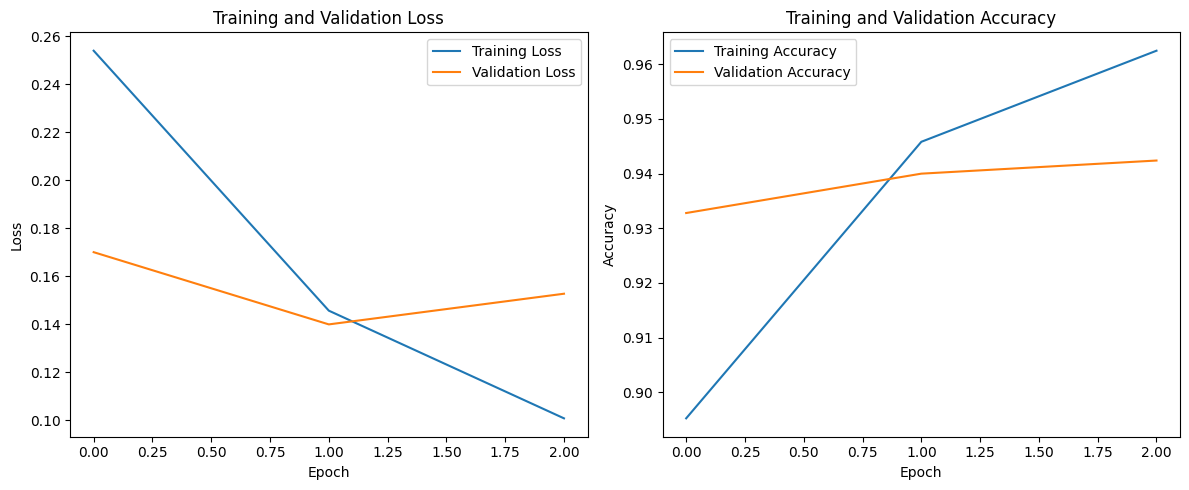

In [10]:
plt.figure(figsize=(12, 5))

# กราฟความสูญเสีย
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# กราฟความแม่นยำ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

## 💾 Cell 11: บันทึกโมเดล

In [11]:
torch.save(model.state_dict(), 'bert_coffee_sentiment_model.pt')
print("Model saved as 'bert_coffee_sentiment_model.pt'")


Model saved as 'bert_coffee_sentiment_model.pt'


## 💬 Cell 12: การใช้โมเดลเพื่อทำนายรีวิวใหม่

In [18]:
def predict_sentiment(review_text, model, tokenizer, device):
    # ทำความสะอาดข้อความ
    review_text = clean_text(review_text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # ย้ายไปยังอุปกรณ์ที่เหมาะสม
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # ทำนาย
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
    
    # แปลผลลัพธ์
    sentiment = "Positive" if preds.item() == 1 else "Negative"
    
    return sentiment

# ตัวอย่างการทำนาย (สามารถเปลื่ยนได้เพื่อจะนำนายจริง)
example_reviews = [
    "Elegant, immersive, unique. Butterscotch, honeysuckle, cocoa nib, coconut, muscat grape, bergamot in aroma and cup. Layered, intense, sparkling acidity; very smooth, syrupy mouthfeel. Long, incense-like finish with notes of honeysuckle and bergamot and undertones of muscat and cocoa nib.",
    "Terrible coffee, way too bitter and left a bad aftertaste. Would not recommend."
]

print("\nExample predictions:")
for review in example_reviews:
    sentiment = predict_sentiment(review, model, tokenizer, device)
    print(f"Review: {review}")
    print(f"Predicted sentiment: {sentiment}\n")


Example predictions:
Review: Elegant, immersive, unique. Butterscotch, honeysuckle, cocoa nib, coconut, muscat grape, bergamot in aroma and cup. Layered, intense, sparkling acidity; very smooth, syrupy mouthfeel. Long, incense-like finish with notes of honeysuckle and bergamot and undertones of muscat and cocoa nib.
Predicted sentiment: Positive

Review: Terrible coffee, way too bitter and left a bad aftertaste. Would not recommend.
Predicted sentiment: Negative

